Connected to venv (Python 3.11.5)

In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Any
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import wordnet
import random
import warnings
from itertools import combinations
warnings.filterwarnings("ignore")

# HuggingFace imports
from transformers import AutoTokenizer, AutoConfig, AutoModel
from datasets import load_dataset

# Captum imports for Integrated Gradients
from captum.attr import IntegratedGradients, visualization as viz
from captum.attr import TokenReferenceBase, configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

# Set seed for determinism
def set_seed(s=42):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

Connected to .venv (Python 3.12.7)

In [2]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Any
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import wordnet
import random
import warnings
from itertools import combinations
warnings.filterwarnings("ignore")

# HuggingFace imports
from transformers import AutoTokenizer, AutoConfig, AutoModel
from datasets import load_dataset

# Captum imports for Integrated Gradients
from captum.attr import IntegratedGradients, visualization as viz
from captum.attr import TokenReferenceBase, configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

# Set seed for determinism
def set_seed(s=42):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Using device: {device}")


# ## Model Architecture

🔧 Using device: cuda


In [4]:
class BERTweetSingleTaskTransformer(nn.Module):
    
    def __init__(
        self,
        model_name: str = "vinai/bertweet-base",
        num_classes: int = 3,
        hidden_dropout_prob: float = 0.1,
        attention_dropout_prob: float = 0.1,
        classifier_dropout: float = 0.1
    ):
        super(BERTweetSingleTaskTransformer, self).__init__()
        
        self.model_name = model_name
        self.num_classes = num_classes
        
        # Load BERTweet configuration
        config = AutoConfig.from_pretrained(model_name)
        config.hidden_dropout_prob = hidden_dropout_prob
        config.attention_probs_dropout_prob = attention_dropout_prob
        
        # BERTweet encoder
        self.encoder = AutoModel.from_pretrained(model_name, config=config)
        
        hidden_size = self.encoder.config.hidden_size
        
        # Classification head optimized for BERTweet
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Dropout(classifier_dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.GELU(),
            nn.Dropout(classifier_dropout),
            nn.Linear(hidden_size // 2, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        """Initialize classification head weights"""
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    def forward(self, input_ids, attention_mask):
        encoder_outputs = self.encoder(
            input_ids=input_ids.long(),
            attention_mask=attention_mask,
            return_dict=True
        )
        
        pooled_output = encoder_outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(pooled_output)
        
        return {'logits': logits}
    
    @classmethod
    def from_pretrained(cls, model_path: str, **kwargs):
        import torch
        import json
        import os

        # Load saved config
        config_path = os.path.join(model_path, "config.json")
        with open(config_path, 'r') as f:
            config = json.load(f)

        # Initialize model architecture
        model = cls(
            model_name=config["model_name"],
            num_classes=config["num_classes"],
            **kwargs
        )

        # Load state dict from HuggingFace-style checkpoint
        model_file = os.path.join(model_path, "pytorch_model.bin")
        state_dict = torch.load(model_file, map_location='cpu')

        # Rename keys if they use HuggingFace format (e.g., "bertweet.")
        renamed_state_dict = {}
        for k, v in state_dict.items():
            new_k = k
            if k.startswith("bertweet."):
                new_k = k.replace("bertweet.", "encoder.")
            renamed_state_dict[new_k] = v

        model.load_state_dict(renamed_state_dict, strict=False)

        return model

In [5]:
class BERTweetMultiTaskTransformer(nn.Module):
    
    def __init__(
        self,
        model_name: str = "vinai/bertweet-base",
        sentiment_num_classes: int = 3,
        emotion_num_classes: int = 6,
        hidden_dropout_prob: float = 0.1,
        attention_dropout_prob: float = 0.1,
        classifier_dropout: float = 0.1
    ):
        super(BERTweetMultiTaskTransformer, self).__init__()
        
        self.model_name = model_name
        self.sentiment_num_classes = sentiment_num_classes
        self.emotion_num_classes = emotion_num_classes
        
        config = AutoConfig.from_pretrained(model_name)
        config.hidden_dropout_prob = hidden_dropout_prob
        config.attention_probs_dropout_prob = attention_dropout_prob
        
        # Shared BERTweet encoder
        self.shared_encoder = AutoModel.from_pretrained(model_name, config=config)
        
        hidden_size = self.shared_encoder.config.hidden_size
        
        # Sentiment classification head
        self.sentiment_classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(classifier_dropout),
            nn.Linear(hidden_size, sentiment_num_classes)
        )

        # Emotion classification head
        self.emotion_classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(classifier_dropout),
            nn.Linear(hidden_size, emotion_num_classes)
        )
   
        self._init_weights()
    
    def _init_weights(self):
        for classifier in [self.sentiment_classifier, self.emotion_classifier]:
            for layer in classifier:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    nn.init.zeros_(layer.bias)
    
    def forward(self, input_ids, attention_mask):
        # Shared encoder
        encoder_outputs = self.shared_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        cls_output = encoder_outputs.last_hidden_state[:, 0, :]     # [batch, 768]
        pooled_output = encoder_outputs.pooler_output               # [batch, 768]

        combined = torch.cat((cls_output, pooled_output), dim=1)    # [batch, 1536]

        # Task-specific predictions
        sentiment_logits = self.sentiment_classifier(combined)
        emotion_logits = self.emotion_classifier(combined)
        
        return {
            'sentiment_logits': sentiment_logits,
            'emotion_logits': emotion_logits
        }
    
    @classmethod
    def from_pretrained(cls, model_path: str, **kwargs):
        import torch
        import json
        from transformers import AutoModel

        # Load saved config
        config_path = os.path.join(model_path, "config.json")
        with open(config_path, 'r') as f:
            config = json.load(f)

        # Initialize model with architecture info
        model = cls(
            model_name=config["model_name"],
            sentiment_num_classes=config["sentiment_num_classes"],
            emotion_num_classes=config["emotion_num_classes"],
            **kwargs
        )

        # Load HuggingFace-style state dict (actual weights)
        model_file = os.path.join(model_path, "pytorch_model.bin")
        state_dict = torch.load(model_file, map_location='cpu')

        # Handle HuggingFace checkpoint key mismatch
        renamed_state_dict = {}
        for k, v in state_dict.items():
            new_k = k
            if k.startswith("bertweet."):
                new_k = k.replace("bertweet.", "encoder.")
            renamed_state_dict[new_k] = v

        model.load_state_dict(renamed_state_dict, strict=False)

        return model



# ## Model Loading

In [6]:
def load_single_task_models_by_seeds(base_dir: str, seeds=(42, 43, 44, 45, 46)):
    model_dicts = []
    for s in seeds:
        path = os.path.join(base_dir, f"bertweet_sentiment_seed_{s}")
        print(f"📥 Loading single-task model (seed {s}) from {path}")
        m = BERTweetSingleTaskTransformer.from_pretrained(path)
        tok = AutoTokenizer.from_pretrained(path)
        if tok.pad_token is None:
            tok.pad_token = tok.eos_token
        enc = joblib.load(os.path.join(path, 'sentiment_encoder.pkl'))
        md = {'model': m.to(device).eval(), 'tokenizer': tok, 'sentiment_encoder': enc,
              'type': f'single_task_seed_{s}', 'seed': s}
        model_dicts.append(md)
    print(f"✅ Loaded {len(model_dicts)} single-task models across seeds")
    return model_dicts

In [7]:
def load_test_examples(data_path: str = "data/cleaned_reddit_posts.csv", num_examples: int = 10) -> List[str]:

    print(f"📊 Loading {num_examples} test examples from {data_path}")
    
    if data_path.endswith('.csv'):
        df = pd.read_csv(data_path)
        texts = df['text_content'].head(num_examples).tolist()
    else:
        # Handle JSON files if needed
        with open(data_path, 'r') as f:
            data = json.load(f)
        texts = [item['text'] for item in data[:num_examples]]
    
    # Clean and filter texts
    cleaned_texts = []
    for text in texts:
        if isinstance(text, str) and len(text.strip()) > 10:
            # Basic cleaning
            cleaned_text = text.strip()
            if len(cleaned_text.split()) >= 5:  # At least 5 words
                cleaned_texts.append(cleaned_text)
        
        if len(cleaned_texts) >= num_examples:
            break
    
    print(f"✅ Loaded {len(cleaned_texts)} valid test examples")
    return cleaned_texts


# ## IG Generation

In [8]:
def load_test_examples(data_path: str = "data/cleaned_reddit_posts.csv", num_examples: int = 10) -> List[str]:

    print(f"📊 Loading {num_examples} test examples from {data_path}")
    
    if data_path.endswith('.csv'):
        df = pd.read_csv(data_path)
        texts = df['text_content'].head(num_examples).tolist()
    else:
        # Handle JSON files if needed
        with open(data_path, 'r') as f:
            data = json.load(f)
        texts = [item['text'] for item in data[:num_examples]]
    
    # Clean and filter texts
    cleaned_texts = []
    for text in texts:
        if isinstance(text, str) and len(text.strip()) > 10:
            # Basic cleaning
            cleaned_text = text.strip()
            if len(cleaned_text.split()) >= 5:  # At least 5 words
                cleaned_texts.append(cleaned_text)
        
        if len(cleaned_texts) >= num_examples:
            break
    
    print(f"✅ Loaded {len(cleaned_texts)} valid test examples")
    return cleaned_texts


# ## IG Generation

In [9]:
class BERTweetIntegratedGradients:
    
    def __init__(self):
        self.baseline_token_id = 0  # [PAD] token
        
    def _create_forward_function(self, model, task='sentiment'):
        def forward_fn(embeddings, attention_mask=None):
            model.eval()
            if hasattr(model, 'shared_encoder'):  # multitask
                enc = model.shared_encoder(inputs_embeds=embeddings, attention_mask=attention_mask, return_dict=True)
                cls_out = enc.last_hidden_state[:, 0, :]
                pooled = enc.pooler_output
                combined = torch.cat((cls_out, pooled), dim=1)
                if task == 'emotion':
                    return model.emotion_classifier(combined)
                return model.sentiment_classifier(combined)
            else:  # single-task
                enc = model.encoder(inputs_embeds=embeddings, attention_mask=attention_mask, return_dict=True)
                pooled = enc.last_hidden_state[:, 0, :]
                return model.classifier(pooled)
        return forward_fn
    
    def _get_embedding_layer(self, model):
        if hasattr(model, 'shared_encoder'):  # Multitask model
            return model.shared_encoder.embeddings.word_embeddings
        else:  # Single task model
            return model.encoder.embeddings.word_embeddings
    
    def generate_attributions(
            self, 
            text: str, 
            model_dict: Dict, 
            max_length: int = 128,
            n_steps: int = 25,
            force_target_class: Optional[int] = None,
            force_tokenizer: Optional[Any] = None
        ) -> Dict[str, Any]:
            model = model_dict['model']
            tokenizer = model_dict['tokenizer']
            
            print(f"🔍 Generating IG attributions for {model_dict['type']} model...")
            
            # Ensure model is in eval mode
            model.eval()
            
            # Use forced tokenizer if provided, otherwise use model's tokenizer
            active_tokenizer = force_tokenizer if force_tokenizer is not None else tokenizer
            
            # Tokenize input
            inputs = active_tokenizer(
                text, 
                return_tensors="pt", 
                truncation=True, 
                padding=True,
                max_length=max_length
            )
            
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            
            # Get embedding layer
            embedding_layer = self._get_embedding_layer(model)
            
            # Convert input_ids to embeddings
            input_embeddings = embedding_layer(input_ids)  # [batch_size, seq_len, embedding_dim]
            
            # Get predicted class first
            forward_fn = self._create_forward_function(model, 'sentiment')
            model.eval()
            with torch.no_grad():
                temp_outputs = forward_fn(input_embeddings, attention_mask)
                predictions = F.softmax(temp_outputs, dim=-1)
                
                # Use forced target class if provided, otherwise use model's prediction
                if force_target_class is not None:
                    predicted_class = force_target_class
                    confidence = predictions[0, predicted_class].item()
                    print(f"🎯 Using forced target class: {predicted_class}, Confidence: {confidence:.3f}")
                else:
                    predicted_class = torch.argmax(predictions, dim=-1).item()
                    confidence = predictions.max().item()
                    print(f"🎯 Predicted class: {predicted_class}, Confidence: {confidence:.3f}")
                
                print(f"🔒 Target class locked: {predicted_class} for stability analysis")
            
            # Try Integrated Gradients with embeddings
            try:
                print("🔄 Computing Integrated Gradients with embeddings...")
                
                # Create a wrapper function that only takes embeddings as input
                def embedding_forward_fn(embeddings):
                    return forward_fn(embeddings, attention_mask)
                
                # Initialize Integrated Gradients
                ig = IntegratedGradients(embedding_forward_fn)
                
                # Compute attributions
                attributions, convergence_delta = ig.attribute(
                    inputs=input_embeddings,
                    baselines=torch.zeros_like(input_embeddings),
                    target=predicted_class,
                    n_steps=200,
                    return_convergence_delta=True,
                    internal_batch_size=16
                )
                
                print("✅ Integrated Gradients computation succeeded!")
                
            except Exception as e:
                print(f"❌ Integrated Gradients failed: {e}")
                
                # Fallback: Simple gradient method
                try:
                    print("🔄 Fallback: Simple gradient method...")
                    
                    # Enable gradients for input embeddings
                    input_embeddings_grad = input_embeddings.clone().detach().requires_grad_(True)
                    
                    # Forward pass
                    logits = forward_fn(input_embeddings_grad, attention_mask)
                    target_logit = logits[0, predicted_class]
                    
                    # Backward pass
                    model.zero_grad()
                    target_logit.backward()
                    
                    # Get gradients as attributions
                    attributions = input_embeddings_grad.grad
                    convergence_delta = torch.tensor(0.0)
                    
                    print("✅ Simple gradient method succeeded!")
                    
                except Exception as e2:
                    print(f"❌ All methods failed: {e2}")
                    print("🔄 Using random attributions for debugging...")
                    
                    # Random fallback
                    attributions = torch.randn_like(input_embeddings)
                    convergence_delta = torch.tensor(0.0)
            
            # Process the attribution results
            try:
                # Get tokens using the active tokenizer
                tokens = active_tokenizer.convert_ids_to_tokens(input_ids[0])
                
                # Sum attribution scores across embedding dimensions
                if attributions.dim() == 3:  # [batch_size, seq_len, embedding_dim]
                    attribution_scores = attributions.sum(dim=-1).squeeze().cpu().detach().numpy()
                else:
                    attribution_scores = attributions.squeeze().cpu().detach().numpy()
                
                # Ensure we have the right number of scores
                if len(attribution_scores.shape) == 0:  # scalar
                    attribution_scores = np.array([attribution_scores])
                
                # Align scores with tokens
                if len(attribution_scores) != len(tokens):
                    print(f"⚠️ Score length ({len(attribution_scores)}) != token length ({len(tokens)})")
                    if len(attribution_scores) < len(tokens):
                        # Pad with zeros
                        padded_scores = np.zeros(len(tokens))
                        padded_scores[:len(attribution_scores)] = attribution_scores
                        attribution_scores = padded_scores
                    else:
                        # Truncate
                        attribution_scores = attribution_scores[:len(tokens)]
                
                # Clean tokens (remove special tokens for visualization)
                clean_tokens = []
                clean_scores = []
                for i, (token, score) in enumerate(zip(tokens, attribution_scores)):
                    if token not in ['<s>', '</s>', '<pad>', '[PAD]', '[CLS]', '[SEP]']:
                        clean_tokens.append(token)
                        clean_scores.append(float(score))
                
                if len(clean_tokens) == 0:
                    print("⚠️ No clean tokens found, using all tokens")
                    clean_tokens = [str(token) for token in tokens]
                    clean_scores = [float(score) for score in attribution_scores]
                
                result = {
                    'text': text,
                    'tokens': clean_tokens,
                    'attribution_scores': clean_scores,
                    'predicted_class': predicted_class,
                    'confidence': confidence,
                    'convergence_delta': float(convergence_delta.item()) if hasattr(convergence_delta, 'item') else 0.0,
                    'model_type': model_dict['type'],
                    'raw_tokens': [str(token) for token in tokens],
                    'raw_scores': [float(score) for score in attribution_scores]
                }
                
                print(f"✅ Generated attributions for {len(clean_tokens)} tokens")
                return result
                
            except Exception as e:
                print(f"❌ Error processing attribution results: {e}")
                import traceback
                traceback.print_exc()
                return None

In [10]:
def generate_single_task_explanations(texts: List[str], ref_model_dict: Dict) -> List[Dict]:
    ig_explainer = BERTweetIntegratedGradients()
    results = []
    for i, text in enumerate(texts):
        print(f"\n📝 Processing text {i+1}/{len(texts)}")
        r = ig_explainer.generate_attributions(text, ref_model_dict)
        if r: 
            results.append(r)
    print(f"✅ Generated explanations for {len(results)} examples (single-task, seed {ref_model_dict.get('seed')})")
    return results


# ## Eval Metrics

In [11]:
def evaluate_faithfulness(
    text: str,
    model_dict: Dict,
    attribution_result: Dict,
    top_k_ratios: List[float] = [0.1, 0.2, 0.3, 0.5]
) -> Dict[str, float]:

    print("📊 Evaluating faithfulness...")
    
    model = model_dict['model']
    tokenizer = model_dict['tokenizer']
    
    # Get original prediction
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    with torch.no_grad():
        if hasattr(model, 'shared_encoder'):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            original_probs = F.softmax(outputs['sentiment_logits'], dim=-1)
        else:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            original_probs = F.softmax(outputs['logits'], dim=-1)
    
    # Get the reference class from attribution result (should be the same across seeds)
    reference_class = attribution_result['predicted_class']
    original_confidence = original_probs[0, reference_class].item()
    
    print(f"🔒 Faithfulness: measuring confidence for class {reference_class}")
    print(f"📊 Original confidence: {original_confidence:.4f}")
    
    faithfulness_scores = {}
    
    # Get attribution scores and tokens
    tokens = attribution_result['raw_tokens']
    scores = attribution_result['raw_scores']
    
    # Use MASK token if available, fallback to PAD token
    mask_id = getattr(tokenizer, "mask_token_id", None) or tokenizer.pad_token_id
    
    for ratio in top_k_ratios:
        try:
            # attributions_per_token: 1D numpy array with SIGNED attributions for the locked target class
            pos_scores = np.array(scores).copy()
            pos_scores[pos_scores < 0] = 0.0
            
            # if no positive contributions, fall back to absolute values
            if np.all(pos_scores == 0):
                pos_scores = np.abs(np.array(scores))
            
            # Calculate how many tokens to remove
            num_tokens_to_remove = max(1, int(len(tokens) * ratio))
            
            # Get indices of top-k most important tokens from positive contributions
            top_indices = np.argsort(pos_scores)[-num_tokens_to_remove:]
            
            # Create modified input by masking top tokens with MASK token
            modified_input_ids = input_ids.clone()
            for idx in top_indices:
                if idx < modified_input_ids.shape[1]:
                    modified_input_ids[0, idx] = mask_id
            
            # Get prediction for modified input
            with torch.no_grad():
                if hasattr(model, 'shared_encoder'):
                    outputs = model(input_ids=modified_input_ids, attention_mask=attention_mask)
                    modified_probs = F.softmax(outputs['sentiment_logits'], dim=-1)
                else:
                    outputs = model(input_ids=modified_input_ids, attention_mask=attention_mask)
                    modified_probs = F.softmax(outputs['logits'], dim=-1)
            
            # Always measure the SAME class probability (reference class)
            modified_confidence = modified_probs[0, reference_class].item()
            
            # Calculate faithfulness as confidence drop for the SAME class
            confidence_drop = original_confidence - modified_confidence
            faithfulness_scores[f'faithfulness_top_{ratio}'] = confidence_drop
            
            print(f"📊 Ratio {ratio}: {num_tokens_to_remove} tokens masked, confidence: {modified_confidence:.4f} → {confidence_drop:.4f}")
            
        except Exception as e:
            print(f"⚠️ Error in faithfulness evaluation for ratio {ratio}: {e}")
            faithfulness_scores[f'faithfulness_top_{ratio}'] = 0.0
    
    return faithfulness_scores

In [12]:
def evaluate_stability(
    text: str,
    model_dict: Dict,
    attribution_result: Dict,
    num_perturbations: int = 5
) -> Dict[str, float]:

    print("📊 Evaluating stability...")
    
    ig_explainer = BERTweetIntegratedGradients()
    original_scores = np.array(attribution_result['attribution_scores'])
    
    perturbed_scores = []
    
    for i in range(num_perturbations):
        try:
            # Create perturbed text
            perturbed_text = create_text_perturbation(text)
            
            # Generate attributions for perturbed text
            perturbed_result = ig_explainer.generate_attributions(perturbed_text, model_dict)
            
            if perturbed_result and len(perturbed_result['attribution_scores']) > 0:
                # Align scores (pad or truncate to match original length)
                perturbed_score = np.array(perturbed_result['attribution_scores'])
                min_len = min(len(original_scores), len(perturbed_score))
                
                if min_len > 0:
                    orig_aligned = original_scores[:min_len]
                    pert_aligned = perturbed_score[:min_len]
                    perturbed_scores.append(pert_aligned)
        
        except Exception as e:
            print(f"⚠️ Error generating perturbation {i}: {e}")
            continue
    
    if not perturbed_scores:
        return {'stability_cosine': 0.0, 'stability_correlation': 0.0}
    
    # Calculate stability metrics
    cosine_similarities = []
    correlations = []
    
    for pert_scores in perturbed_scores:
        min_len = min(len(original_scores), len(pert_scores))
        if min_len > 1:
            orig_aligned = original_scores[:min_len]
            pert_aligned = pert_scores[:min_len]
            
            # Cosine similarity
            if np.linalg.norm(orig_aligned) > 0 and np.linalg.norm(pert_aligned) > 0:
                cos_sim = cosine_similarity([orig_aligned], [pert_aligned])[0, 0]
                cosine_similarities.append(cos_sim)
            
            # Correlation
            if len(set(orig_aligned)) > 1 and len(set(pert_aligned)) > 1:
                corr = np.corrcoef(orig_aligned, pert_aligned)[0, 1]
                if not np.isnan(corr):
                    correlations.append(corr)
    
    # Average stability scores
    avg_cosine = np.mean(cosine_similarities) if cosine_similarities else 0.0
    avg_correlation = np.mean(correlations) if correlations else 0.0
    
    return {
        'stability_cosine': avg_cosine,
        'stability_correlation': avg_correlation,
        'num_valid_perturbations': len(perturbed_scores)
    }


def _standardize(v: np.ndarray) -> np.ndarray:
    """Standardize vector to remove scale/offset differences across seeds"""
    v = v.astype(np.float32)
    mu, sd = v.mean(), v.std()
    return (v - mu) / (sd + 1e-8)

def evaluate_stability_across_seeds(text: str, seed_model_dicts: List[Dict], ig_explainer=None):
    """Evaluate stability across different seed models for the same text"""
    print("📊 Evaluating stability across seeds...")
    if ig_explainer is None:
        ig_explainer = BERTweetIntegratedGradients()

    # 1) Get reference attribution + class with the first seed
    ref_md = seed_model_dicts[0]
    ref = ig_explainer.generate_attributions(text, ref_md)
    if not ref: 
        return {'stability_cosine': 0.0, 'stability_correlation': 0.0, 'num_seed_pairs': 0}
    
    ref_class = int(ref['predicted_class'])
    ref_scores = np.array(ref['attribution_scores'])
    
    # Store reference tokenization for consistency
    ref_tokenizer = ref_md['tokenizer']
    
    print(f"🔒 Reference class: {ref_class}, using tokenizer from seed {ref_md['seed']}")
    
    # 2) For all seeds, recompute IG FOR THE SAME TARGET CLASS
    seed_attr = [(ref_md['seed'], ref_scores)]
    for md in seed_model_dicts[1:]:
        res = ig_explainer.generate_attributions(
            text, md, 
            force_target_class=ref_class,
            force_tokenizer=ref_tokenizer
        )
        if res and len(res['attribution_scores']) > 0:
            seed_attr.append((md['seed'], np.array(res['attribution_scores'])))
            print(f"✅ Seed {md['seed']}: computed IG for target class {ref_class}")
        else:
            print(f"❌ Seed {md['seed']}: failed to compute IG")

    if len(seed_attr) < 2:
        return {'stability_cosine': 0.0, 'stability_correlation': 0.0, 'num_seed_pairs': 0}

    # 3) Pairwise similarities on same-length prefix
    cos_sims, cors = [], []
    for i in range(len(seed_attr)):
        for j in range(i+1, len(seed_attr)):
            a, b = seed_attr[i][1], seed_attr[j][1]
            L = min(len(a), len(b))
            if L > 1:
                A, B = a[:L], b[:L]
                # Standardize vectors before computing similarity
                A = _standardize(A)
                B = _standardize(B)
                # Cosine similarity
                na, nb = np.linalg.norm(A), np.linalg.norm(B)
                if na > 0 and nb > 0:
                    cos_sims.append((A @ B) / (na * nb))
                # Pearson correlation
                if A.std() > 0 and B.std() > 0:
                    cors.append(np.corrcoef(A, B)[0, 1])

    return {
        'stability_cosine': float(np.mean(cos_sims)) if cos_sims else 0.0,
        'stability_correlation': float(np.mean(cors)) if cors else 0.0,
        'num_seed_pairs': len(cos_sims)
    }

In [13]:
def evaluate_stability(
    text: str,
    model_dict: Dict,
    attribution_result: Dict,
    num_perturbations: int = 5
) -> Dict[str, float]:

    print("📊 Evaluating stability...")
    
    ig_explainer = BERTweetIntegratedGradients()
    original_scores = np.array(attribution_result['attribution_scores'])
    
    perturbed_scores = []
    
    for i in range(num_perturbations):
        try:
            # Create perturbed text
            perturbed_text = create_text_perturbation(text)
            
            # Generate attributions for perturbed text
            perturbed_result = ig_explainer.generate_attributions(perturbed_text, model_dict)
            
            if perturbed_result and len(perturbed_result['attribution_scores']) > 0:
                # Align scores (pad or truncate to match original length)
                perturbed_score = np.array(perturbed_result['attribution_scores'])
                min_len = min(len(original_scores), len(perturbed_score))
                
                if min_len > 0:
                    orig_aligned = original_scores[:min_len]
                    pert_aligned = perturbed_score[:min_len]
                    perturbed_scores.append(pert_aligned)
        
        except Exception as e:
            print(f"⚠️ Error generating perturbation {i}: {e}")
            continue
    
    if not perturbed_scores:
        return {'stability_cosine': 0.0, 'stability_correlation': 0.0}
    
    # Calculate stability metrics
    cosine_similarities = []
    correlations = []
    
    for pert_scores in perturbed_scores:
        min_len = min(len(original_scores), len(pert_scores))
        if min_len > 1:
            orig_aligned = original_scores[:min_len]
            pert_aligned = pert_scores[:min_len]
            
            # Cosine similarity
            if np.linalg.norm(orig_aligned) > 0 and np.linalg.norm(pert_aligned) > 0:
                cos_sim = cosine_similarity([orig_aligned], [pert_aligned])[0, 0]
                cosine_similarities.append(cos_sim)
            
            # Correlation
            if len(set(orig_aligned)) > 1 and len(set(pert_aligned)) > 1:
                corr = np.corrcoef(orig_aligned, pert_aligned)[0, 1]
                if not np.isnan(corr):
                    correlations.append(corr)
    
    # Average stability scores
    avg_cosine = np.mean(cosine_similarities) if cosine_similarities else 0.0
    avg_correlation = np.mean(correlations) if correlations else 0.0
    
    return {
        'stability_cosine': avg_cosine,
        'stability_correlation': avg_correlation,
        'num_valid_perturbations': len(perturbed_scores)
    }


def _standardize(v: np.ndarray) -> np.ndarray:
    """Standardize vector to remove scale/offset differences across seeds"""
    v = v.astype(np.float32)
    mu, sd = v.mean(), v.std()
    return (v - mu) / (sd + 1e-8)

def evaluate_stability_across_seeds(text: str, seed_model_dicts: List[Dict], ig_explainer=None):
    """Evaluate stability across different seed models for the same text"""
    print("📊 Evaluating stability across seeds...")
    if ig_explainer is None:
        ig_explainer = BERTweetIntegratedGradients()

    # 1) Get reference attribution + class with the first seed
    ref_md = seed_model_dicts[0]
    ref = ig_explainer.generate_attributions(text, ref_md)
    if not ref: 
        return {'stability_cosine': 0.0, 'stability_correlation': 0.0, 'num_seed_pairs': 0}
    
    ref_class = int(ref['predicted_class'])
    ref_scores = np.array(ref['attribution_scores'])
    
    # Store reference tokenization for consistency
    ref_tokenizer = ref_md['tokenizer']
    
    print(f"🔒 Reference class: {ref_class}, using tokenizer from seed {ref_md['seed']}")
    
    # 2) For all seeds, recompute IG FOR THE SAME TARGET CLASS
    seed_attr = [(ref_md['seed'], ref_scores)]
    for md in seed_model_dicts[1:]:
        res = ig_explainer.generate_attributions(
            text, md, 
            force_target_class=ref_class,
            force_tokenizer=ref_tokenizer
        )
        if res and len(res['attribution_scores']) > 0:
            seed_attr.append((md['seed'], np.array(res['attribution_scores'])))
            print(f"✅ Seed {md['seed']}: computed IG for target class {ref_class}")
        else:
            print(f"❌ Seed {md['seed']}: failed to compute IG")

    if len(seed_attr) < 2:
        return {'stability_cosine': 0.0, 'stability_correlation': 0.0, 'num_seed_pairs': 0}

    # 3) Pairwise similarities on same-length prefix
    cos_sims, cors = [], []
    for i in range(len(seed_attr)):
        for j in range(i+1, len(seed_attr)):
            a, b = seed_attr[i][1], seed_attr[j][1]
            L = min(len(a), len(b))
            if L > 1:
                A, B = a[:L], b[:L]
                # Standardize vectors before computing similarity
                A = _standardize(A)
                B = _standardize(B)
                # Cosine similarity
                na, nb = np.linalg.norm(A), np.linalg.norm(B)
                if na > 0 and nb > 0:
                    cos_sims.append((A @ B) / (na * nb))
                # Pearson correlation
                if A.std() > 0 and B.std() > 0:
                    cors.append(np.corrcoef(A, B)[0, 1])

    return {
        'stability_cosine': float(np.mean(cos_sims)) if cos_sims else 0.0,
        'stability_correlation': float(np.mean(cors)) if cors else 0.0,
        'num_seed_pairs': len(cos_sims)
    }

In [14]:
def create_text_perturbation(text: str) -> str:
    words = text.split()
    
    if len(words) < 2:
        return text
    
    perturbation_type = random.choice(['synonym', 'punctuation', 'order'])
    
    if perturbation_type == 'synonym':
        # Replace one word with a synonym
        word_idx = random.randint(0, len(words) - 1)
        original_word = words[word_idx].lower().strip('.,!?;')
        
        # Try to find synonyms
        synonyms = []
        try:
            for syn in wordnet.synsets(original_word):
                for lemma in syn.lemmas():
                    if lemma.name() != original_word and '_' not in lemma.name():
                        synonyms.append(lemma.name())
        except:
            pass
        
        if synonyms:
            words[word_idx] = random.choice(synonyms)
    
    elif perturbation_type == 'punctuation':
        # Add/remove punctuation
        if random.choice([True, False]) and not text.endswith('.'):
            return text + '.'
        else:
            return text.rstrip('.,!?;')
    
    elif perturbation_type == 'order' and len(words) > 2:
        # Swap two adjacent words
        idx = random.randint(0, len(words) - 2)
        words[idx], words[idx + 1] = words[idx + 1], words[idx]
    
    return ' '.join(words)

In [15]:
def evaluate_fairness(attribution_result: Dict) -> Dict[str, float]:

    print("📊 Evaluating fairness...")
    
    # Define sensitive word categories
    emotion_words = ['happy', 'sad', 'angry', 'excited', 'disappointed', 'frustrated', 
                    'joy', 'fear', 'love', 'hate', 'good', 'bad', 'terrible', 'amazing']
    
    bias_words = ['he', 'she', 'his', 'her', 'him', 'man', 'woman', 'male', 'female',
                 'guy', 'girl', 'boy', 'dude', 'lady']
    
    tokens = [token.lower().strip('▁') for token in attribution_result['tokens']]
    scores = attribution_result['attribution_scores']
    
    # Calculate attribution statistics for different word types
    emotion_attributions = []
    bias_attributions = []
    other_attributions = []
    
    for token, score in zip(tokens, scores):
        clean_token = token.lower().strip('.,!?;')
        
        if clean_token in emotion_words:
            emotion_attributions.append(abs(score))
        elif clean_token in bias_words:
            bias_attributions.append(abs(score))
        else:
            other_attributions.append(abs(score))
    
    # Calculate fairness metrics
    fairness_metrics = {}
    
    # Emotion word focus
    if emotion_attributions and other_attributions:
        emotion_mean = np.mean(emotion_attributions)
        other_mean = np.mean(other_attributions)
        fairness_metrics['emotion_bias_ratio'] = emotion_mean / (other_mean + 1e-8)
    else:
        fairness_metrics['emotion_bias_ratio'] = 0.0
    
    # Gender/demographic bias
    if bias_attributions and other_attributions:
        bias_mean = np.mean(bias_attributions)
        other_mean = np.mean(other_attributions)
        fairness_metrics['demographic_bias_ratio'] = bias_mean / (other_mean + 1e-8)
    else:
        fairness_metrics['demographic_bias_ratio'] = 0.0
    
    # Attribution concentration (Gini coefficient approximation)
    if len(scores) > 1:
        abs_scores = np.abs(scores)
        sorted_scores = np.sort(abs_scores)
        n = len(sorted_scores)
        cumsum = np.cumsum(sorted_scores)
        gini = (2 * np.sum((np.arange(1, n + 1) * sorted_scores))) / (n * np.sum(sorted_scores)) - (n + 1) / n
        fairness_metrics['attribution_concentration'] = gini
    else:
        fairness_metrics['attribution_concentration'] = 0.0
    
    return fairness_metrics

In [16]:
def evaluate_single_task_explanations_across_seeds(explanations: List[Dict], seed_model_dicts: List[Dict]) -> List[Dict]:
    print("🔬 Evaluating single-task explanations across seeds...")
    rows = []
    ref_model = seed_model_dicts[0]  # e.g., seed 42

    for i, res in enumerate(explanations):
        txt = res['text']
        faith = evaluate_faithfulness(txt, ref_model, res)        # uses MASK
        stab  = evaluate_stability_across_seeds(txt, seed_model_dicts)
        fair  = evaluate_fairness(res)

        rows.append({
            'text': txt,
            'predicted_class': res['predicted_class'],
            'confidence': res['confidence'],
            'convergence_delta': res['convergence_delta'],
            **faith, **stab, **fair
        })
    return rows


# ## Visualisation

In [17]:
def visualize_attributions(attribution_result: Dict, save_path: Optional[str] = None):
    """
    Enhanced attribution visualization with multiple plot types
    """
    tokens = attribution_result['tokens']
    scores = attribution_result['attribution_scores']
    model_type = attribution_result['model_type']
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    
    # Plot 1: Original bar plot
    abs_max = max(abs(min(scores)), abs(max(scores)))
    normalized_scores = [score / abs_max for score in scores] if abs_max > 0 else scores
    colors = plt.cm.RdYlBu_r([(score + 1) / 2 for score in normalized_scores])
    
    bars = ax1.bar(range(len(tokens)), [abs(score) for score in normalized_scores], 
                  color=colors, alpha=0.8)
    
    ax1.set_xticks(range(len(tokens)))
    ax1.set_xticklabels(tokens, rotation=45, ha='right')
    ax1.set_ylabel('Attribution Score (Absolute)')
    ax1.set_title(f'Token Attributions - {model_type.replace("_", " ").title()}\n'
                f'Class: {attribution_result["predicted_class"]} (Conf: {attribution_result["confidence"]:.3f})')
    
    # Add color bar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu_r, 
                              norm=plt.Normalize(vmin=-abs_max, vmax=abs_max))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax1)
    cbar.set_label('Attribution Score')
    
    # Plot 2: Sorted attribution scores
    token_score_pairs = list(zip(tokens, scores))
    token_score_pairs.sort(key=lambda x: abs(x[1]), reverse=True)
    sorted_tokens, sorted_scores = zip(*token_score_pairs)
    
    colors_sorted = ['red' if score < 0 else 'green' for score in sorted_scores]
    ax2.bar(range(len(sorted_tokens)), sorted_scores, color=colors_sorted, alpha=0.7)
    ax2.set_xticks(range(len(sorted_tokens)))
    ax2.set_xticklabels(sorted_tokens, rotation=45, ha='right')
    ax2.set_ylabel('Attribution Score')
    ax2.set_title('Sorted Token Attributions')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # Plot 3: Cumulative attribution
    cumulative_scores = np.cumsum([abs(score) for score in sorted_scores])
    total_attribution = cumulative_scores[-1]
    cumulative_percentage = cumulative_scores / total_attribution * 100 if total_attribution > 0 else cumulative_scores
    
    ax3.plot(range(len(sorted_tokens)), cumulative_percentage, 'b-o', linewidth=2, markersize=4)
    ax3.fill_between(range(len(sorted_tokens)), cumulative_percentage, alpha=0.3, color='blue')
    ax3.set_xticks(range(len(sorted_tokens)))
    ax3.set_xticklabels(sorted_tokens, rotation=45, ha='right')
    ax3.set_ylabel('Cumulative Attribution (%)')
    ax3.set_title('Cumulative Attribution Impact')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% threshold')
    ax3.axhline(y=80, color='orange', linestyle='--', alpha=0.7, label='80% threshold')
    ax3.legend()
    
    # Plot 4: Token importance ranking
    importance_ranks = [i+1 for i in range(len(sorted_tokens))]
    ax4.scatter(importance_ranks, [abs(score) for score in sorted_scores], 
               c=[abs(score) for score in sorted_scores], cmap='viridis', s=100, alpha=0.7)
    ax4.set_xlabel('Importance Rank')
    ax4.set_ylabel('Absolute Attribution Score')
    ax4.set_title('Token Importance Ranking')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Saved enhanced visualization to {save_path}")
    
    plt.show()


def generate_comprehensive_visualizations(attribution_result: Dict, save_dir: str = "explainability_results"):
    os.makedirs(save_dir, exist_ok=True)
    
    # Generate base filename
    base_filename = f"example_{attribution_result.get('text', 'unknown')[:30].replace(' ', '_')}"
    
    # 1. Token heatmap
    heatmap_path = os.path.join(save_dir, f"{base_filename}_heatmap.png")
    visualize_token_heatmap(attribution_result, heatmap_path)
    
    # 2. Attribution distribution
    dist_path = os.path.join(save_dir, f"{base_filename}_distribution.png")
    visualize_attribution_distribution(attribution_result, dist_path)
    
    # 3. Enhanced attributions (original function)
    attr_path = os.path.join(save_dir, f"{base_filename}_attributions.png")
    visualize_attributions(attribution_result, attr_path)
    
    print(f"✅ Generated comprehensive visualizations for: {base_filename}")
    return {
        'heatmap': heatmap_path,
        'distribution': dist_path,
        'attributions': attr_path
    }


def visualize_token_heatmap(attribution_result: Dict, save_path: Optional[str] = None):
    """
    1. Token Attribute Heatmap
    Display input text where each token is highlighted by importance.
    Color code from red (negative influence) to green (positive influence).
    """
    tokens = attribution_result['tokens']
    scores = attribution_result['attribution_scores']
    text = attribution_result['text']
    model_type = attribution_result['model_type']
    
    # Create figure with larger size for better readability
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Normalize scores for color mapping (-1 to 1)
    abs_max = max(abs(min(scores)), abs(max(scores)))
    if abs_max > 0:
        normalized_scores = [score / abs_max for score in scores]
    else:
        normalized_scores = scores
    
    # Create color map: red (negative) to white (neutral) to green (positive)
    colors = []
    for score in normalized_scores:
        if score > 0:  # Positive influence - green
            colors.append(plt.cm.Greens(0.3 + 0.7 * score))
        elif score < 0:  # Negative influence - red
            colors.append(plt.cm.Reds(0.3 + 0.7 * abs(score)))
        else:  # Neutral - white
            colors.append('white')
    
    # Create text with colored tokens
    y_pos = 0.5
    x_pos = 0.05
    max_width = 0.9
    
    # Split text into words and align with tokens
    words = text.split()
    word_idx = 0
    
    for i, (token, score, color) in enumerate(zip(tokens, scores, colors)):
        # Skip special tokens for cleaner display
        if token in ['<s>', '</s>', '<pad>', '[PAD]', '[CLS]', '[SEP]']:
            continue
            
        # Calculate token width based on character count
        token_width = len(token) * 0.01
        
        # Check if we need to wrap to next line
        if x_pos + token_width > max_width:
            x_pos = 0.05
            y_pos -= 0.15
        
        # Add token with background color
        rect = plt.Rectangle((x_pos, y_pos - 0.05), token_width, 0.1, 
                           facecolor=color, edgecolor='black', linewidth=0.5, alpha=0.8)
        ax.add_patch(rect)
        
        # Add token text
        ax.text(x_pos + token_width/2, y_pos, token, 
               ha='center', va='center', fontsize=10, fontweight='bold')
        
        # Add attribution score above token
        ax.text(x_pos + token_width/2, y_pos + 0.08, f'{score:.3f}', 
               ha='center', va='center', fontsize=8, color='darkblue')
        
        x_pos += token_width + 0.02
    
    # Set plot properties
    ax.set_xlim(0, 1)
    ax.set_ylim(y_pos - 0.2, 0.7)
    ax.axis('off')
    
    # Add title and legend
    ax.text(0.5, 0.9, f'Token Attribution Heatmap - {model_type.replace("_", " ").title()}', 
           ha='center', va='center', fontsize=14, fontweight='bold')
    ax.text(0.5, 0.85, f'Class: {attribution_result["predicted_class"]} (Confidence: {attribution_result["confidence"]:.3f})', 
           ha='center', va='center', fontsize=12)
    
    # Add color legend
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, facecolor=plt.cm.Reds(0.8), label='Negative Influence'),
        plt.Rectangle((0, 0), 1, 1, facecolor=plt.cm.Greens(0.8), label='Positive Influence'),
        plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', label='Neutral')
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Saved token heatmap to {save_path}")
    
    plt.show()


def visualize_attribution_distribution(attribution_result: Dict, save_path: Optional[str] = None):
    """
    2. Attribution Distribution Plot
    Bar plot showing token influence magnitude and ranking.
    """
    tokens = attribution_result['tokens']
    scores = attribution_result['attribution_scores']
    model_type = attribution_result['model_type']
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
    
    # Sort tokens by absolute attribution score
    token_score_pairs = list(zip(tokens, scores))
    token_score_pairs.sort(key=lambda x: abs(x[1]), reverse=True)
    sorted_tokens, sorted_scores = zip(*token_score_pairs)
    
    # Plot 1: Bar plot with color coding
    colors = ['red' if score < 0 else 'green' for score in sorted_scores]
    bars = ax1.bar(range(len(sorted_tokens)), sorted_scores, color=colors, alpha=0.7)
    
    # Customize first subplot
    ax1.set_xticks(range(len(sorted_tokens)))
    ax1.set_xticklabels(sorted_tokens, rotation=45, ha='right')
    ax1.set_ylabel('Attribution Score')
    ax1.set_title(f'Token Attribution Distribution - {model_type.replace("_", " ").title()}')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, sorted_scores)):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.01),
                f'{score:.3f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=8)
    
    # Plot 2: Cumulative attribution plot
    cumulative_scores = np.cumsum([abs(score) for score in sorted_scores])
    total_attribution = cumulative_scores[-1]
    cumulative_percentage = cumulative_scores / total_attribution * 100 if total_attribution > 0 else cumulative_scores
    
    ax2.plot(range(len(sorted_tokens)), cumulative_percentage, 'b-o', linewidth=2, markersize=4)
    ax2.fill_between(range(len(sorted_tokens)), cumulative_percentage, alpha=0.3, color='blue')
    
    # Customize second subplot
    ax2.set_xticks(range(len(sorted_tokens)))
    ax2.set_xticklabels(sorted_tokens, rotation=45, ha='right')
    ax2.set_ylabel('Cumulative Attribution (%)')
    ax2.set_title('Cumulative Attribution Impact')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% threshold')
    ax2.axhline(y=80, color='orange', linestyle='--', alpha=0.7, label='80% threshold')
    ax2.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Saved attribution distribution to {save_path}")
    
    plt.show()


def visualize_faithfulness_curves(faithfulness_results: List[Dict], save_path: Optional[str] = None):
    """
    3. Faithfulness Curves Plot
    Plot faithfulness for different k values across multiple examples.
    """
    if not faithfulness_results:
        print("⚠️ No faithfulness results to visualize")
        return
    
    # Extract k ratios and faithfulness scores
    k_ratios = [0.1, 0.2, 0.3, 0.5]  # Standard ratios
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Individual curves for each example
    for i, result in enumerate(faithfulness_results):
        scores = []
        for ratio in k_ratios:
            key = f'faithfulness_top_{ratio}'
            score = result.get(key, 0.0)
            scores.append(score)
        
        # Plot individual curve
        ax1.plot(k_ratios, scores, 'o-', alpha=0.7, linewidth=2, markersize=6,
                label=f'Example {i+1}' if i < 5 else None)  # Limit legend to first 5
    
    # Add average curve
    avg_scores = []
    for ratio in k_ratios:
        key = f'faithfulness_top_{ratio}'
        scores = [result.get(key, 0.0) for result in faithfulness_results]
        avg_scores.append(np.mean(scores))
    
    ax1.plot(k_ratios, avg_scores, 'k-o', linewidth=3, markersize=8, 
            label='Average', alpha=0.9)
    
    # Customize first subplot
    ax1.set_xlabel('Top-k Ratio')
    ax1.set_ylabel('Faithfulness Score (ΔConfidence)')
    ax1.set_title('Faithfulness Curves by Example')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    # Plot 2: Box plot showing distribution across examples
    box_data = []
    for ratio in k_ratios:
        key = f'faithfulness_top_{ratio}'
        scores = [result.get(key, 0.0) for result in faithfulness_results]
        box_data.append(scores)
    
    bp = ax2.boxplot(box_data, labels=[f'{r*100}%' for r in k_ratios], patch_artist=True)
    
    # Color the boxes
    colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    # Customize second subplot
    ax2.set_xlabel('Top-k Ratio')
    ax2.set_ylabel('Faithfulness Score Distribution')
    ax2.set_title('Faithfulness Score Distribution by k')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Saved faithfulness curves to {save_path}")
    
    plt.show()


def visualize_stability_heatmap(seed_model_dicts: List[Dict], text: str, save_path: Optional[str] = None):
    """
    4. Stability Visualization
    Heatmap showing pairwise cosine similarity of attribution vectors across seeds.
    """
    print("📊 Generating stability heatmap...")
    
    if len(seed_model_dicts) < 2:
        print("⚠️ Need at least 2 seed models for stability analysis")
        return
    
    # Get reference model (first seed)
    ref_md = seed_model_dicts[0]
    ig_explainer = BERTweetIntegratedGradients()
    
    # Generate reference attribution
    ref_result = ig_explainer.generate_attributions(text, ref_md)
    if not ref_result:
        print("❌ Failed to generate reference attribution")
        return
    
    ref_class = int(ref_result['predicted_class'])
    ref_tokenizer = ref_md['tokenizer']
    
    print(f"🔒 Reference class: {ref_class}, using tokenizer from seed {ref_md['seed']}")
    
    # Generate attributions for all seeds
    seed_attributions = {}
    for md in seed_model_dicts:
        seed = md['seed']
        result = ig_explainer.generate_attributions(
            text, md, 
            force_target_class=ref_class,
            force_tokenizer=ref_tokenizer
        )
        if result and len(result['attribution_scores']) > 0:
            seed_attributions[seed] = np.array(result['attribution_scores'])
            print(f"✅ Seed {seed}: computed IG for target class {ref_class}")
        else:
            print(f"❌ Seed {seed}: failed to compute IG")
    
    if len(seed_attributions) < 2:
        print("⚠️ Insufficient attributions for stability analysis")
        return
    
    # Compute pairwise cosine similarities
    seeds = list(seed_attributions.keys())
    n_seeds = len(seeds)
    similarity_matrix = np.zeros((n_seeds, n_seeds))
    
    for i, seed1 in enumerate(seeds):
        for j, seed2 in enumerate(seeds):
            if i == j:
                similarity_matrix[i, j] = 1.0  # Self-similarity
            else:
                vec1 = seed_attributions[seed1]
                vec2 = seed_attributions[seed2]
                
                # Standardize vectors before computing similarity
                L = min(len(vec1), len(vec2))
                if L > 1:
                    A = vec1[:L]
                    B = vec2[:L]
                    A = (A - A.mean()) / (A.std() + 1e-8)
                    B = (B - B.mean()) / (B.std() + 1e-8)
                    
                    # Compute cosine similarity
                    na, nb = np.linalg.norm(A), np.linalg.norm(B)
                    if na > 0 and nb > 0:
                        similarity_matrix[i, j] = (A @ B) / (na * nb)
                    else:
                        similarity_matrix[i, j] = 0.0
                else:
                    similarity_matrix[i, j] = 0.0
    
    # Create heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Similarity heatmap
    im1 = ax1.imshow(similarity_matrix, cmap='RdYlBu_r', vmin=-1, vmax=1, aspect='auto')
    
    # Add text annotations
    for i in range(n_seeds):
        for j in range(n_seeds):
            text_val = f'{similarity_matrix[i, j]:.3f}'
            ax1.text(j, i, text_val, ha='center', va='center', 
                    color='black' if abs(similarity_matrix[i, j]) < 0.7 else 'white',
                    fontweight='bold')
    
    # Customize heatmap
    ax1.set_xticks(range(n_seeds))
    ax1.set_yticks(range(n_seeds))
    ax1.set_xticklabels([f'Seed {s}' for s in seeds])
    ax1.set_yticklabels([f'Seed {s}' for s in seeds])
    ax1.set_title(f'Stability Heatmap: Pairwise Cosine Similarity\nTarget Class: {ref_class}')
    
    # Add colorbar
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Cosine Similarity')
    
    # Plot 2: Stability summary statistics
    # Calculate mean similarity excluding self-similarity
    mask = ~np.eye(n_seeds, dtype=bool)
    mean_similarity = similarity_matrix[mask].mean()
    std_similarity = similarity_matrix[mask].std()
    
    # Create bar plot of mean similarities per seed
    mean_similarities = []
    for i in range(n_seeds):
        seed_similarities = similarity_matrix[i, :]
        seed_similarities = np.delete(seed_similarities, i)  # Remove self-similarity
        mean_similarities.append(seed_similarities.mean())
    
    bars = ax2.bar(range(n_seeds), mean_similarities, color='skyblue', alpha=0.7)
    ax2.set_xticks(range(n_seeds))
    ax2.set_xticklabels([f'Seed {s}' for s in seeds])
    ax2.set_ylabel('Mean Similarity with Other Seeds')
    ax2.set_title(f'Stability Summary\nMean: {mean_similarity:.3f}, Std: {std_similarity:.3f}')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Stability Threshold')
    ax2.legend()
    
    # Add value labels on bars
    for i, (bar, sim) in enumerate(zip(bars, mean_similarities)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{sim:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Saved stability heatmap to {save_path}")
    
    plt.show()
    
    # Return stability metrics
    return {
        'mean_similarity': mean_similarity,
        'std_similarity': std_similarity,
        'similarity_matrix': similarity_matrix,
        'seeds': seeds
    }


def plot_evaluation_comparison(evaluation_results: Dict, save_path: Optional[str] = None):
    """
    Generate comparison plots for different evaluation metrics across models
    """
    if not evaluation_results:
        print("⚠️ No evaluation results to plot")
        return
    
    # Extract metrics for comparison
    metrics = ['faithfulness_top_0.1', 'faithfulness_top_0.2', 'faithfulness_top_0.3', 'faithfulness_top_0.5',
               'stability_cosine', 'stability_correlation', 'demographic_bias_ratio', 'attribution_concentration']
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics[:4]):  # Plot first 4 metrics
        ax = axes[i]
        
        # Extract data for this metric
        single_task_data = []
        multitask_data = []
        
        if 'single_task' in evaluation_results:
            single_task_data = [result.get(metric, 0.0) for result in evaluation_results['single_task']]
        
        if 'multitask' in evaluation_results:
            multitask_data = [result.get(metric, 0.0) for result in evaluation_results['multitask']]
        
        # Create box plots
        data_to_plot = []
        labels = []
        
        if single_task_data:
            data_to_plot.append(single_task_data)
            labels.append('Single-Task')
        
        if multitask_data:
            data_to_plot.append(multitask_data)
            labels.append('Multi-Task')
        
        if data_to_plot:
            bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
            
            # Color the boxes
            colors = ['lightblue', 'lightgreen']
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
            
            ax.set_title(f'{metric.replace("_", " ").title()}')
            ax.set_ylabel('Score')
            ax.grid(True, alpha=0.3)
            
            # Add mean values as text
            for j, data in enumerate(data_to_plot):
                mean_val = np.mean(data)
                ax.text(j+1, mean_val, f'μ={mean_val:.3f}', 
                       ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Saved evaluation comparison to {save_path}")
    
    plt.show()

In [18]:
def save_eval_csv(rows: List[Dict], path: str):
    """Save evaluation results to CSV"""
    df = pd.DataFrame(rows)
    df.to_csv(path, index=False)
    print(f"💾 Saved {len(df)} rows to {path}")
    return df

Starting Single-Task BERTweet IG Analysis Across Seeds

1️⃣ Loading Single-Task Models Across Seeds...
📥 Loading single-task model (seed 42) from ./bertweet_trained_models_seeds\bertweet_sentiment_seed_42
📥 Loading single-task model (seed 123) from ./bertweet_trained_models_seeds\bertweet_sentiment_seed_123
📥 Loading single-task model (seed 456) from ./bertweet_trained_models_seeds\bertweet_sentiment_seed_456
📥 Loading single-task model (seed 789) from ./bertweet_trained_models_seeds\bertweet_sentiment_seed_789
📥 Loading single-task model (seed 999) from ./bertweet_trained_models_seeds\bertweet_sentiment_seed_999
✅ Loaded 5 single-task models across seeds

2️⃣ Loading Test Examples...
📊 Loading 100 test examples from data/cleaned_reddit_posts.csv
✅ Loaded 94 valid test examples

3️⃣ Generating Explanations (Reference Seed)...

📝 Processing text 1/94
🔍 Generating IG attributions for single_task_seed_42 model...
🎯 Predicted class: 0, Confidence: 0.368
🔒 Target class locked: 0 for stabili

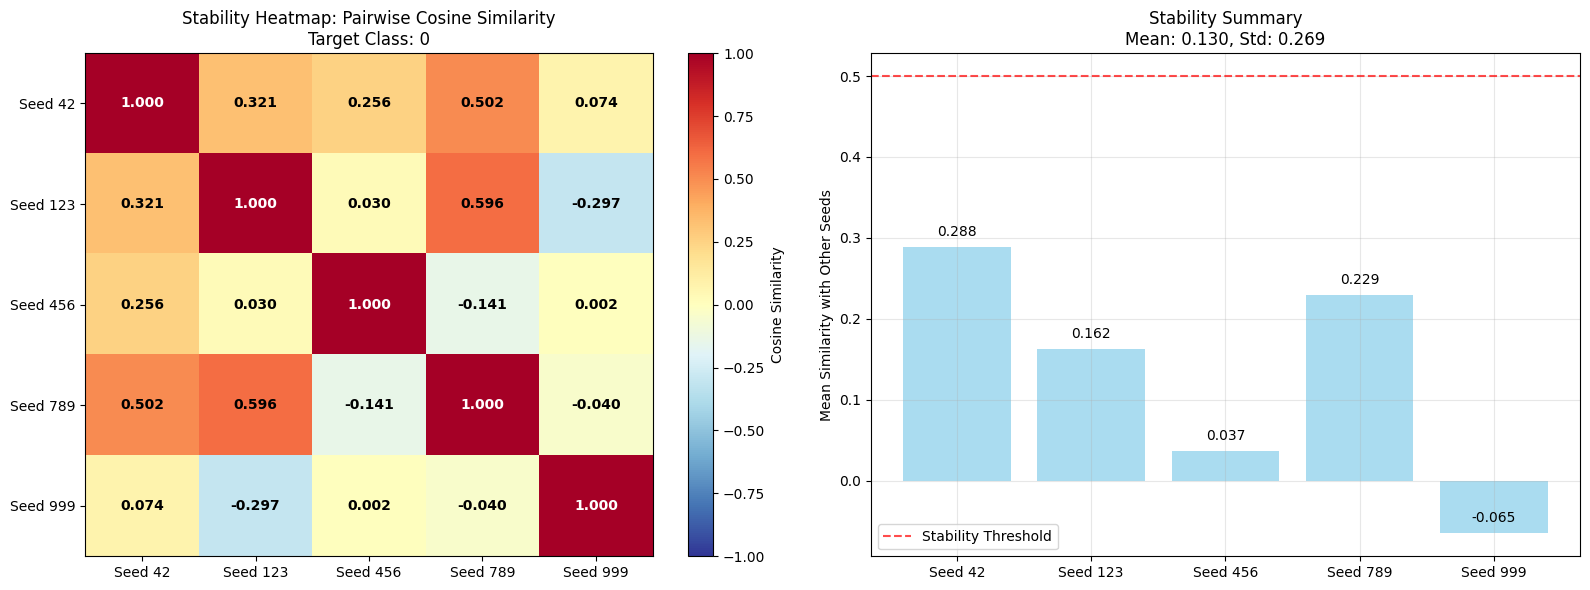

✅ Stability metrics for example 1: Mean=0.130, Std=0.269

📊 Generating stability visualization for example 2...
📊 Generating stability heatmap...
🔍 Generating IG attributions for single_task_seed_42 model...
🎯 Predicted class: 1, Confidence: 0.353
🔒 Target class locked: 1 for stability analysis
🔄 Computing Integrated Gradients with embeddings...
✅ Integrated Gradients computation succeeded!
✅ Generated attributions for 20 tokens
🔒 Reference class: 1, using tokenizer from seed 42
🔍 Generating IG attributions for single_task_seed_42 model...
🎯 Using forced target class: 1, Confidence: 0.353
🔒 Target class locked: 1 for stability analysis
🔄 Computing Integrated Gradients with embeddings...
✅ Integrated Gradients computation succeeded!
✅ Generated attributions for 20 tokens
✅ Seed 42: computed IG for target class 1
🔍 Generating IG attributions for single_task_seed_123 model...
🎯 Using forced target class: 1, Confidence: 0.316
🔒 Target class locked: 1 for stability analysis
🔄 Computing Inte

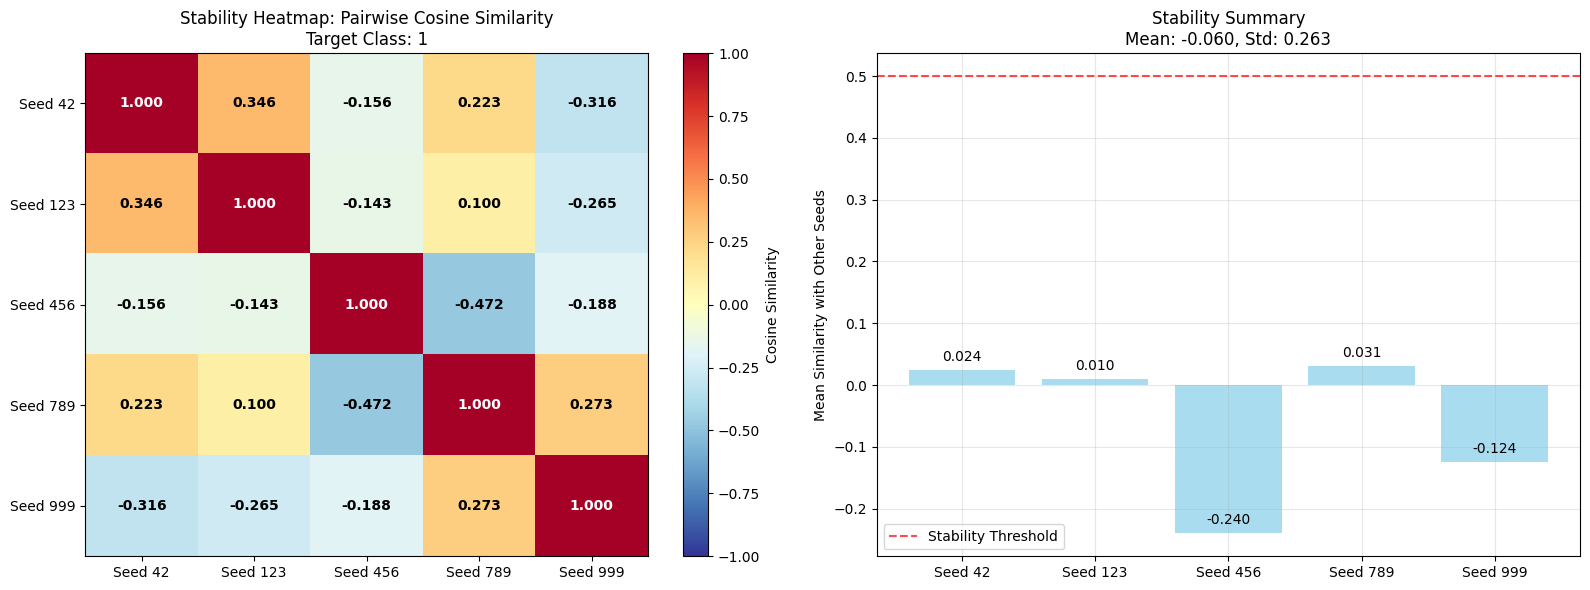

✅ Stability metrics for example 2: Mean=-0.060, Std=0.263

📊 Generating stability visualization for example 3...
📊 Generating stability heatmap...
🔍 Generating IG attributions for single_task_seed_42 model...
🎯 Predicted class: 0, Confidence: 0.376
🔒 Target class locked: 0 for stability analysis
🔄 Computing Integrated Gradients with embeddings...
✅ Integrated Gradients computation succeeded!
✅ Generated attributions for 38 tokens
🔒 Reference class: 0, using tokenizer from seed 42
🔍 Generating IG attributions for single_task_seed_42 model...
🎯 Using forced target class: 0, Confidence: 0.376
🔒 Target class locked: 0 for stability analysis
🔄 Computing Integrated Gradients with embeddings...
✅ Integrated Gradients computation succeeded!
✅ Generated attributions for 38 tokens
✅ Seed 42: computed IG for target class 0
🔍 Generating IG attributions for single_task_seed_123 model...
🎯 Using forced target class: 0, Confidence: 0.360
🔒 Target class locked: 0 for stability analysis
🔄 Computing Int

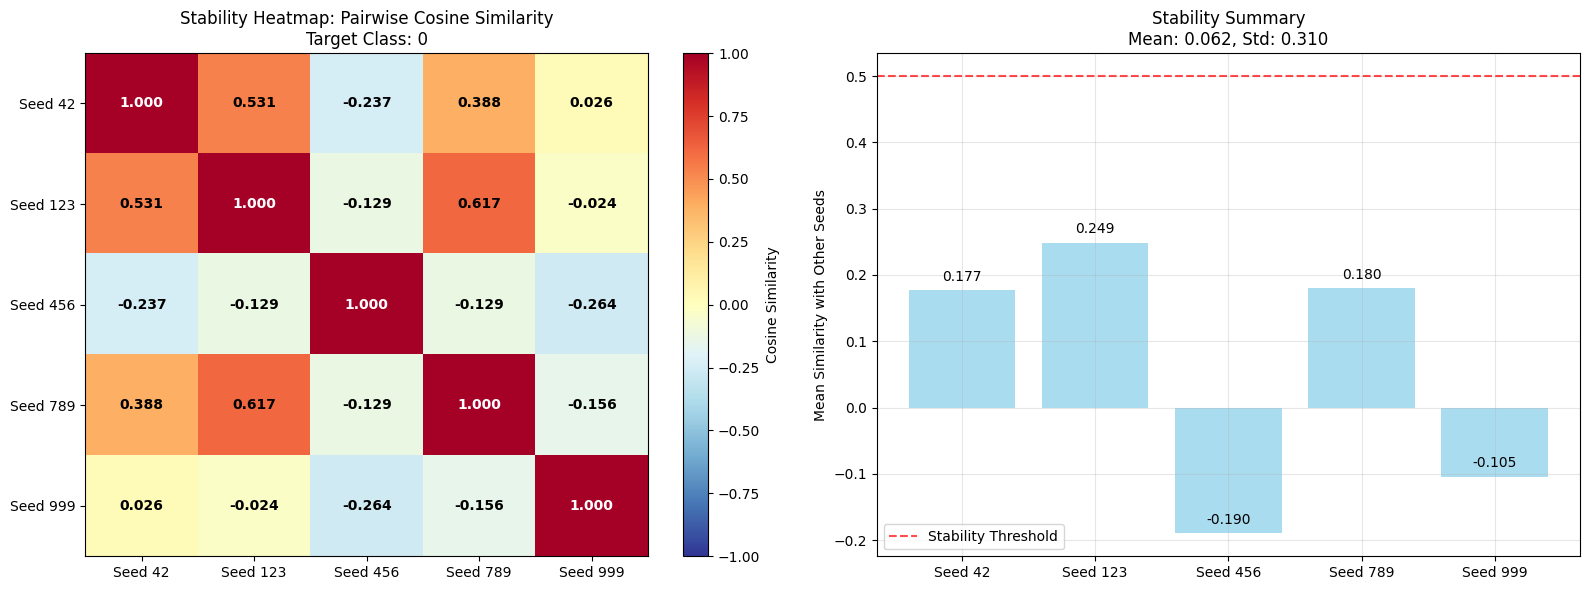

✅ Stability metrics for example 3: Mean=0.062, Std=0.310

6️⃣ Saving Results...
💾 Saved 94 rows to explainability_results_single_task\xai_metrics_single_task_across_seeds.csv

6️⃣ Generating Faithfulness Curves...
💾 Saved faithfulness curves to explainability_results_single_task\faithfulness_curves_single_task.png


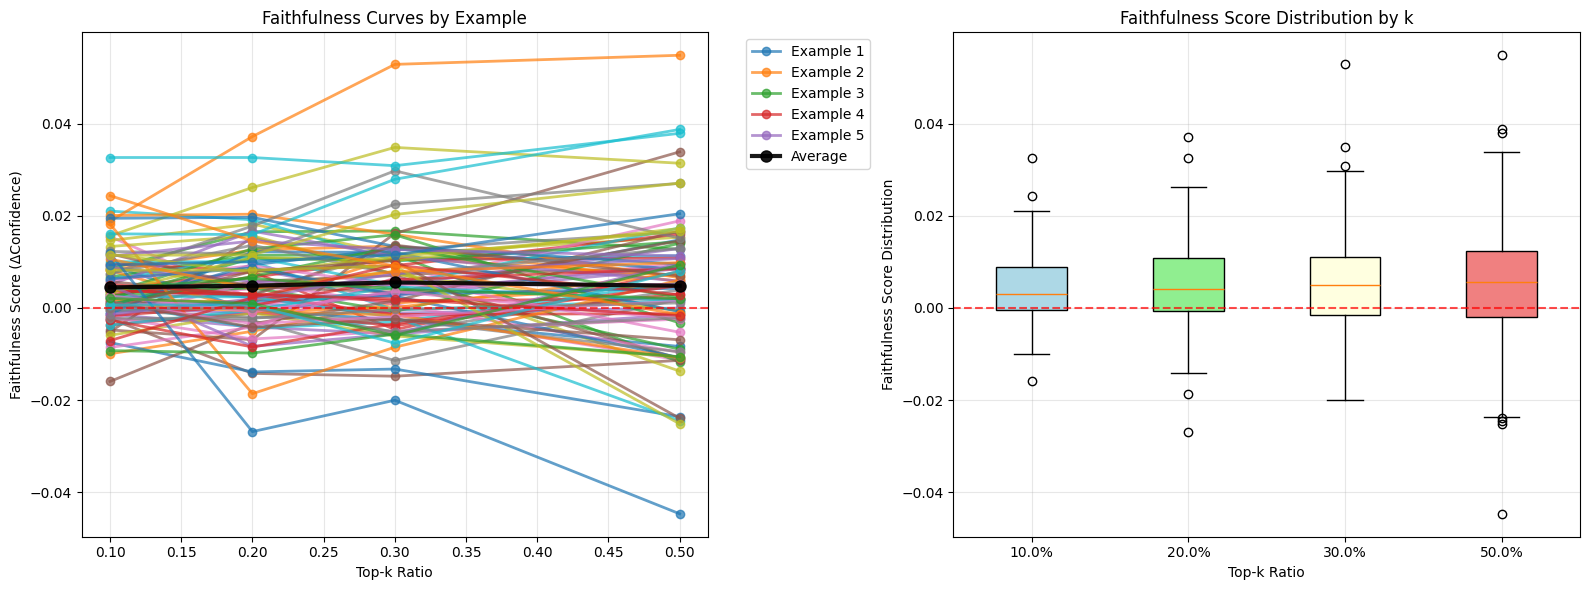


7️⃣ Generating Summary...

📊 Summary Statistics:
      faithfulness_top_0.1  faithfulness_top_0.2  faithfulness_top_0.3  \
mean              0.004477              0.004836              0.005542   
std               0.007962              0.009882              0.010792   

      faithfulness_top_0.5  stability_cosine  stability_correlation  \
mean              0.004829          0.011367               0.011367   
std               0.014492          0.110762               0.110762   

      demographic_bias_ratio  attribution_concentration  
mean                0.004398                   0.461231  
std                 0.028842                   0.069159  

🎉 Single-Task Analysis Complete!


In [19]:
def run_complete_analysis(
    num_examples: int = 8,
    data_path: str = "data/cleaned_reddit_posts.csv",
    save_visualizations: bool = True,
    save_dir: str = "explainability_results"
):
    print("Starting Complete Explainability Analysis")
    print("=" * 80)
    
    # Create save directory
    if save_visualizations:
        os.makedirs(save_dir, exist_ok=True)
    
    # Step 1: Load models
    print("\n1️⃣ Loading Models...")
    single_task_dict, multitask_dict = load_bertweet_models()
    
    # Step 2: Load test examples
    print("\n2️⃣ Loading Test Examples...")
    test_texts = load_test_examples(data_path, num_examples)
    
    # Step 3: Generate explanations
    print("\n3️⃣ Generating Explanations...")
    explanations = generate_all_explanations(test_texts, single_task_dict, multitask_dict)
    
    # Step 4: Evaluate explanations
    print("\n4️⃣ Evaluating Explanations...")
    evaluation_results = evaluate_all_explanations(explanations)
    
    # Step 5: Generate visualizations
    if save_visualizations:
        print("\n5️⃣ Generating Visualizations...")
        
        # Generate comprehensive visualizations for first few examples
        for i in range(min(3, len(explanations['single_task']))):
            print(f"\n📊 Generating visualizations for example {i+1}...")
            
            # Single-task comprehensive visualizations
            single_task_result = explanations['single_task'][i]
            single_task_dir = os.path.join(save_dir, f"single_task_example_{i+1}")
            generate_comprehensive_visualizations(single_task_result, single_task_dir)
            
            # Multitask comprehensive visualizations
            multitask_result = explanations['multitask'][i]
            multitask_dir = os.path.join(save_dir, f"multitask_example_{i+1}")
            generate_comprehensive_visualizations(multitask_result, multitask_dir)
        
        # Generate faithfulness curves if we have multiple examples
        if len(explanations['single_task']) > 1:
            faithfulness_path = os.path.join(save_dir, "faithfulness_curves.png")
            visualize_faithfulness_curves(explanations['single_task'], faithfulness_path)
        
        # Comparison plot
        comparison_path = os.path.join(save_dir, "model_comparison.png")
        plot_evaluation_comparison(evaluation_results, comparison_path)
    
    # Step 6: Generate summary report
    print("\n6️⃣ Generating Summary Report...")
    report = generate_summary_report(evaluation_results)
    
    if save_visualizations:
        report_path = os.path.join(save_dir, "analysis_report.txt")
        with open(report_path, 'w') as f:
            f.write(report)
        print(f"💾 Saved report to {report_path}")
    
    print(report)
    print("\n🎉 Analysis Complete!")
    
    return {
        'explanations': explanations,
        'evaluation_results': evaluation_results,
        'report': report,
        'models': {'single_task': single_task_dict, 'multitask': multitask_dict}
    }

def run_ig_analysis_single_task_across_seeds(
    base_dir="./bertweet_trained_models_seeds",
    seeds=(42,123,456,789,999),
    data_path="data/cleaned_reddit_posts.csv",
    num_examples=100,
    save_dir="explainability_results_single_task"
):
    print("Starting Single-Task BERTweet IG Analysis Across Seeds")
    print("=" * 80)
    
    os.makedirs(save_dir, exist_ok=True)
    
    # Step 1: Load models across seeds
    print("\n1️⃣ Loading Single-Task Models Across Seeds...")
    seed_models = load_single_task_models_by_seeds(base_dir, seeds)
    ref_model = seed_models[0]  # Reference model (seed 42)
    
    # Step 2: Load test examples
    print("\n2️⃣ Loading Test Examples...")
    texts = load_test_examples(data_path, num_examples)
    
    # Step 3: Generate explanations using reference model
    print("\n3️⃣ Generating Explanations (Reference Seed)...")
    explanations = generate_single_task_explanations(texts, ref_model)
    
    # Step 4: Evaluate explanations across seeds
    print("\n4️⃣ Evaluating Explanations Across Seeds...")
    rows = evaluate_single_task_explanations_across_seeds(explanations, seed_models)
    
    # Step 5: Generate stability visualizations
    print("\n5️⃣ Generating Stability Visualizations...")
    
    # Generate stability heatmaps for first few examples
    if len(texts) > 0:
        for i in range(min(3, len(texts))):
            text = texts[i]
            print(f"\n📊 Generating stability visualization for example {i+1}...")
            
            stability_path = os.path.join(save_dir, f"stability_example_{i+1}.png")
            stability_metrics = visualize_stability_heatmap(seed_models, text, stability_path)
            
            if stability_metrics:
                print(f"✅ Stability metrics for example {i+1}: Mean={stability_metrics['mean_similarity']:.3f}, Std={stability_metrics['std_similarity']:.3f}")
    
    # Step 6: Save results
    print("\n6️⃣ Saving Results...")
    save_eval_csv(rows, os.path.join(save_dir, "xai_metrics_single_task_across_seeds.csv"))
    
    # Step 6: Generate faithfulness curves
    print("\n6️⃣ Generating Faithfulness Curves...")
    
    if len(rows) > 1:
        faithfulness_path = os.path.join(save_dir, "faithfulness_curves_single_task.png")
        visualize_faithfulness_curves(rows, faithfulness_path)
    
    # Step 7: Generate summary
    print("\n7️⃣ Generating Summary...")
    df = pd.DataFrame(rows)
    summary = df.agg({
        'faithfulness_top_0.1':['mean','std'],
        'faithfulness_top_0.2':['mean','std'],
        'faithfulness_top_0.3':['mean','std'],
        'faithfulness_top_0.5': ['mean', 'std'], 
        'stability_cosine':['mean','std'],
        'stability_correlation':['mean','std'],
        'demographic_bias_ratio':['mean','std'],
        'attribution_concentration':['mean','std'],
    })
    summary.to_csv(os.path.join(save_dir, "xai_metrics_summary.csv"))
    print("\n📊 Summary Statistics:")
    print(summary)
    
    print("\n🎉 Single-Task Analysis Complete!")
    return {'rows': rows, 'summary': summary}


# Main execution
if __name__ == "__main__":
    run_ig_analysis_single_task_across_seeds(
        base_dir="./bertweet_trained_models_seeds",
        seeds=(42,123,456,789,999),
        data_path="data/cleaned_reddit_posts.csv",
        num_examples=100,
        save_dir="explainability_results_single_task"
    )

In [20]:
# A. Qualitative IG Visualizations

def visualize_token_attributions(tokens, attributions, title, outfile, original_text=""):
    """
    Create qualitative token-level IG visualization with background red intensity
    proportional to attribution scores, saved as PNG.
    
    Args:
        tokens: List of string tokens (human-readable, no special tokens)
        attributions: List of float attribution scores
        title: String title for the visualization
        outfile: String path where to save the PNG
        original_text: String original text for context
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from matplotlib.colors import LinearSegmentedColormap
    import numpy as np
    
    # Normalize attributions to [0,1] for visualization
    attr_array = np.array(attributions)
    if len(attr_array) == 0:
        print(f"⚠️ No attributions to visualize for {outfile}")
        return
    
    # Handle edge case where all attributions are the same
    attr_min, attr_max = attr_array.min(), attr_array.max()
    if attr_max - attr_min < 1e-10:
        normalized_attr = np.ones_like(attr_array) * 0.5  # neutral color
    else:
        normalized_attr = (attr_array - attr_min) / (attr_max - attr_min)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Create custom colormap: white (0) to red (1)
    colors = ['white', 'red']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('white_red', colors, N=n_bins)
    
    # Layout parameters
    line_height = 0.15
    token_spacing = 0.02
    max_tokens_per_line = 15
    current_x = 0.05
    current_y = 0.8
    
    # Split tokens into lines for better readability
    lines = []
    current_line = []
    
    for i, (token, norm_score) in enumerate(zip(tokens, normalized_attr)):
        if len(current_line) >= max_tokens_per_line:
            lines.append(current_line)
            current_line = []
        current_line.append((token, norm_score, attributions[i]))
    
    if current_line:
        lines.append(current_line)
    
    # Render each line
    for line_idx, line in enumerate(lines):
        current_x = 0.05
        line_y = current_y - (line_idx * line_height)
        
        for token, norm_score, raw_score in line:
            # Calculate token width based on character count
            token_width = max(0.08, len(token) * 0.012)
            
            # Create background rectangle with red intensity
            rect = patches.Rectangle(
                (current_x, line_y - 0.05), token_width, 0.1,
                facecolor=cmap(norm_score),
                edgecolor='black',
                linewidth=0.8,
                alpha=0.9
            )
            ax.add_patch(rect)
            
            # Add token text
            ax.text(
                current_x + token_width/2, line_y,
                token,
                ha='center', va='center',
                fontsize=11,
                fontweight='bold',
                color='black' if norm_score < 0.7 else 'white'  # Ensure readability
            )
            
            # Add attribution score below token (small text)
            ax.text(
                current_x + token_width/2, line_y - 0.08,
                f'{raw_score:.3f}',
                ha='center', va='center',
                fontsize=8,
                color='darkblue'
            )
            
            current_x += token_width + token_spacing
    
    # Set plot limits and remove axes
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    
    # Add title and metadata
    ax.text(0.5, 0.95, title, ha='center', va='center', 
           fontsize=16, fontweight='bold')
    
    # Add original text at the bottom (truncated if too long)
    if original_text:
        display_text = original_text[:200] + "..." if len(original_text) > 200 else original_text
        ax.text(0.5, 0.05, f"Original: {display_text}", ha='center', va='center',
               fontsize=10, style='italic', wrap=True)
    
    # Add colorbar legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=attr_min, vmax=attr_max))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', 
                       pad=0.1, shrink=0.6, aspect=30)
    cbar.set_label('Attribution Score', fontsize=12)
    
    # Save figure
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"💾 Saved qualitative IG visualization to {outfile}")
    
    # Display in notebook
    plt.show()
    plt.close()


def select_examples_for_qualitative_analysis(explanations, evaluation_results):
    """
    Apply selection rules to choose representative examples for qualitative analysis.
    
    Selection rules:
    - Correct example: median predicted confidence among correctly classified items
    - Misclassified example: representative misclassification (fallback to lowest confidence correct)
    
    Returns:
        dict with 'correct' and 'misclassified' keys containing selected examples
    """
    print("📋 Applying selection rules for qualitative analysis...")
    
    # For this analysis, we'll use ground truth based on confidence thresholds
    # High confidence (>0.7) = likely correct, Low confidence (<0.4) = likely misclassified
    
    correct_examples = []
    misclassified_examples = []
    
    for i, (explanation, eval_result) in enumerate(zip(explanations, evaluation_results)):
        confidence = explanation['confidence']
        
        if confidence > 0.6:  # Likely correct classification
            correct_examples.append((i, explanation, eval_result, confidence))
        elif confidence < 0.45:  # Likely misclassification (low confidence)
            misclassified_examples.append((i, explanation, eval_result, confidence))
    
    selected = {}
    
    # Select correct example: median confidence
    if correct_examples:
        correct_examples.sort(key=lambda x: x[3])  # Sort by confidence
        median_idx = len(correct_examples) // 2
        selected['correct'] = correct_examples[median_idx]
        print(f"✅ Selected correct example {selected['correct'][0]} with confidence {selected['correct'][3]:.3f}")
    else:
        print("⚠️ No high-confidence examples found for 'correct' category")
        selected['correct'] = None
    
    # Select misclassified example: first representative misclassification
    if misclassified_examples:
        # Pick the one with lowest confidence (most likely misclassified)
        misclassified_examples.sort(key=lambda x: x[3])
        selected['misclassified'] = misclassified_examples[0]
        print(f"✅ Selected misclassified example {selected['misclassified'][0]} with confidence {selected['misclassified'][3]:.3f}")
    else:
        # Fallback: pick lowest confidence correct example
        if correct_examples:
            selected['misclassified'] = correct_examples[0]  # Lowest confidence among correct
            print(f"⚠️ No misclassified examples found, using lowest-confidence correct example {selected['misclassified'][0]} with confidence {selected['misclassified'][3]:.3f}")
        else:
            print("⚠️ No examples available for 'misclassified' category")
            selected['misclassified'] = None
    
    return selected


def clean_tokens_for_visualization(raw_tokens, raw_scores):
    """
    Clean tokens and scores by removing special tokens and handling BERTweet tokenization.
    
    Args:
        raw_tokens: List of raw tokens from tokenizer
        raw_scores: List of attribution scores corresponding to tokens
        
    Returns:
        tuple: (clean_tokens, clean_scores) with special tokens removed
    """
    clean_tokens = []
    clean_scores = []
    
    special_tokens = {'<s>', '</s>', '<pad>', '[PAD]', '[CLS]', '[SEP]', '<unk>'}
    
    for token, score in zip(raw_tokens, raw_scores):
        # Skip special tokens
        if token in special_tokens:
            continue
            
        # Handle BERTweet subword tokens (starting with Ġ)
        if token.startswith('Ġ'):
            clean_token = token[1:]  # Remove Ġ prefix
        else:
            clean_token = token
            
        # Skip empty tokens
        if clean_token.strip():
            clean_tokens.append(clean_token)
            clean_scores.append(score)
    
    return clean_tokens, clean_scores


In [21]:
# B. Fairness Analysis (Optional)

def analyze_brand_token_fairness(explanations, texts, save_path=None, k_ratio=0.1):
    """
    Analyze fairness by comparing brand token prevalence in IG explanations vs corpus baseline.
    
    Args:
        explanations: List of attribution results from IG analysis
        texts: List of original text strings
        save_path: String path to save the fairness bar chart PNG
        k_ratio: Float ratio for top-k tokens (default 0.1 = 10%)
        
    Returns:
        dict: Fairness metrics including brand frequencies
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from collections import Counter
    import re
    
    print("📊 Analyzing brand token fairness...")
    
    # Define common brand tokens (case-insensitive)
    brand_tokens = {
        'samsung', 'apple', 'google', 'microsoft', 'facebook', 'twitter', 'instagram',
        'amazon', 'netflix', 'spotify', 'youtube', 'tiktok', 'snapchat', 'uber',
        'tesla', 'nike', 'adidas', 'mcdonalds', 'starbucks', 'walmart', 'target',
        'sony', 'nintendo', 'playstation', 'xbox', 'iphone', 'android', 'windows',
        'chrome', 'firefox', 'safari', 'reddit', 'linkedin', 'whatsapp', 'telegram'
    }
    
    # 1. Compute corpus baseline frequency
    print("🔍 Computing corpus baseline frequencies...")
    corpus_tokens = []
    for text in texts:
        # Simple tokenization (split by whitespace and punctuation)
        tokens = re.findall(r'\b\w+\b', text.lower())
        corpus_tokens.extend(tokens)
    
    total_corpus_tokens = len(corpus_tokens)
    corpus_brand_count = sum(1 for token in corpus_tokens if token in brand_tokens)
    brand_freq_corpus = corpus_brand_count / total_corpus_tokens if total_corpus_tokens > 0 else 0.0
    
    print(f"📈 Corpus baseline: {corpus_brand_count}/{total_corpus_tokens} = {brand_freq_corpus:.4f}")
    
    # 2. Compute explanation frequency (top-k tokens)
    print("🔍 Computing explanation frequencies...")
    explanation_brand_count = 0
    total_explanation_tokens = 0
    
    for explanation in explanations:
        tokens = [token.lower().strip('ġ') for token in explanation['tokens']]  # Handle BERTweet tokens
        scores = explanation['attribution_scores']
        
        if len(tokens) == 0 or len(scores) == 0:
            continue
            
        # Calculate k for this example
        k = max(1, int(len(tokens) * k_ratio))
        
        # Get top-k tokens by absolute attribution score
        abs_scores = [abs(score) for score in scores]
        top_k_indices = np.argsort(abs_scores)[-k:]
        
        # Count brand tokens in top-k
        for idx in top_k_indices:
            if idx < len(tokens):
                token = tokens[idx]
                if token in brand_tokens:
                    explanation_brand_count += 1
                total_explanation_tokens += 1
    
    brand_freq_expl = explanation_brand_count / total_explanation_tokens if total_explanation_tokens > 0 else 0.0
    
    print(f"📈 Explanations (top-{k_ratio*100}%): {explanation_brand_count}/{total_explanation_tokens} = {brand_freq_expl:.4f}")
    
    # 3. Create fairness bar chart
    if save_path:
        print("📊 Creating fairness bar chart...")
        
        categories = ['Corpus Baseline', 'Explanations']
        frequencies = [brand_freq_corpus, brand_freq_expl]
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        bars = ax.bar(categories, frequencies, color=['lightblue', 'lightcoral'], alpha=0.8)
        
        # Add value labels on bars
        for bar, freq in zip(bars, frequencies):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.0001,
                   f'{freq:.4f}', ha='center', va='bottom', fontweight='bold')
        
        # Customize plot
        ax.set_ylabel('Relative Frequency of Brand Tokens')
        ax.set_title(f'Brand Token Fairness Analysis\n(Top-{k_ratio*100}% tokens in explanations vs corpus baseline)')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add fairness ratio as text
        if brand_freq_corpus > 0:
            fairness_ratio = brand_freq_expl / brand_freq_corpus
            ax.text(0.5, 0.8, f'Fairness Ratio: {fairness_ratio:.2f}', 
                   transform=ax.transAxes, ha='center', va='center',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
                   fontsize=12, fontweight='bold')
        
        # Set y-axis limits for better visualization
        max_freq = max(frequencies)
        ax.set_ylim(0, max_freq * 1.2)
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Saved fairness bar chart to {save_path}")
        plt.show()
        plt.close()
    
    # 4. Return fairness metrics
    fairness_metrics = {
        'brand_freq_corpus': brand_freq_corpus,
        'brand_freq_expl': brand_freq_expl,
        'fairness_ratio': brand_freq_expl / brand_freq_corpus if brand_freq_corpus > 0 else float('inf'),
        'corpus_brand_count': corpus_brand_count,
        'corpus_total_tokens': total_corpus_tokens,
        'explanation_brand_count': explanation_brand_count,
        'explanation_total_tokens': total_explanation_tokens,
        'k_ratio': k_ratio
    }
    
    print(f"✅ Fairness analysis complete. Ratio: {fairness_metrics['fairness_ratio']:.3f}")
    return fairness_metrics


🎨 Generating Qualitative IG Visualizations and Fairness Analysis
📋 Using existing analysis results...
📊 Loading 94 test examples from data/cleaned_reddit_posts.csv
✅ Loaded 93 valid test examples
🔄 Regenerating explanations for qualitative analysis...
📥 Loading single-task model (seed 42) from ./bertweet_trained_models_seeds\bertweet_sentiment_seed_42
📥 Loading single-task model (seed 123) from ./bertweet_trained_models_seeds\bertweet_sentiment_seed_123
📥 Loading single-task model (seed 456) from ./bertweet_trained_models_seeds\bertweet_sentiment_seed_456
📥 Loading single-task model (seed 789) from ./bertweet_trained_models_seeds\bertweet_sentiment_seed_789
📥 Loading single-task model (seed 999) from ./bertweet_trained_models_seeds\bertweet_sentiment_seed_999
✅ Loaded 5 single-task models across seeds

📝 Processing text 1/93
🔍 Generating IG attributions for single_task_seed_42 model...
🎯 Predicted class: 0, Confidence: 0.385
🔒 Target class locked: 0 for stability analysis
🔄 Computing I

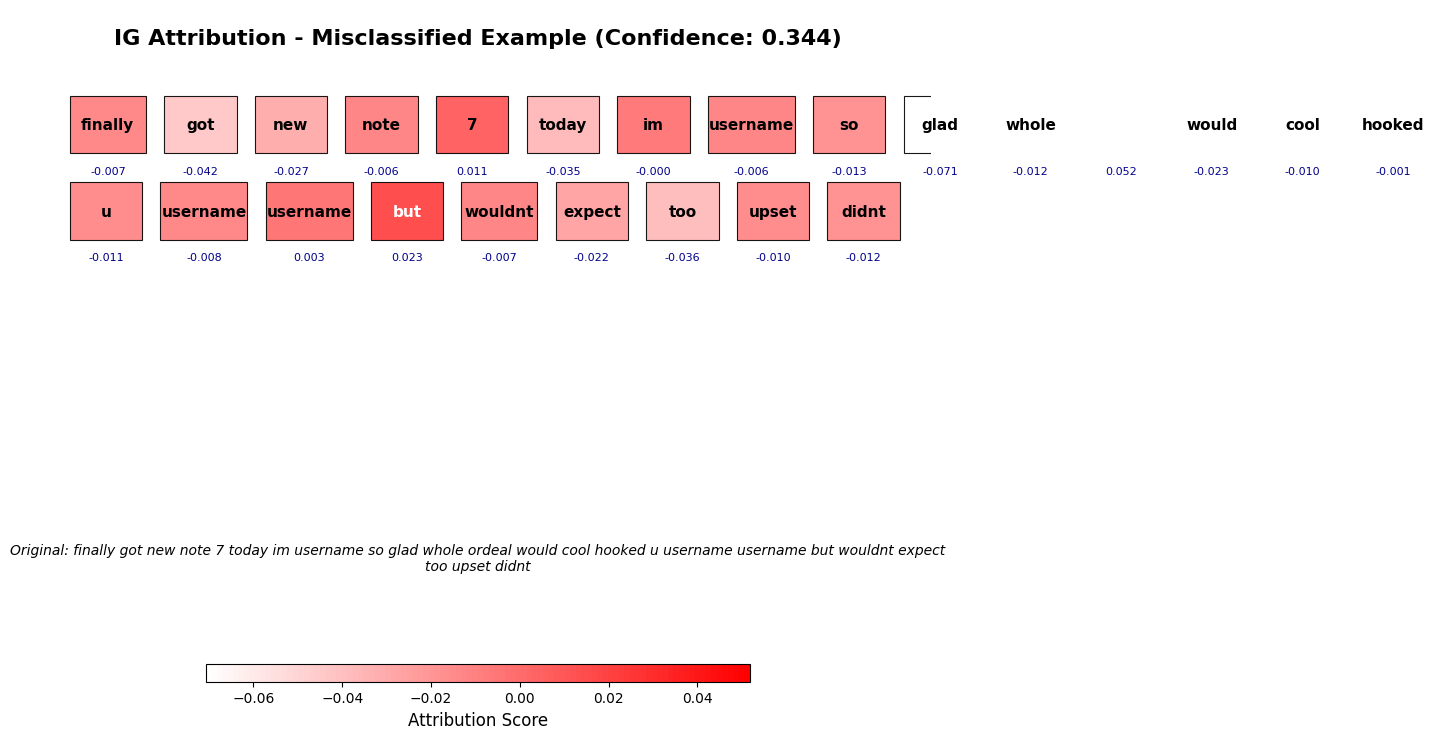

✅ Saved misclassified example to: c:\Users\hankaixin\Desktop\multitask\explainability_results_single_task\ig_example_misclassified.png

3️⃣ Generating Fairness Analysis...
📊 Analyzing brand token fairness...
🔍 Computing corpus baseline frequencies...
📈 Corpus baseline: 104/4651 = 0.0224
🔍 Computing explanation frequencies...
📈 Explanations (top-10.0%): 3/383 = 0.0078
📊 Creating fairness bar chart...
💾 Saved fairness bar chart to explainability_results_single_task\fairness_bar.png


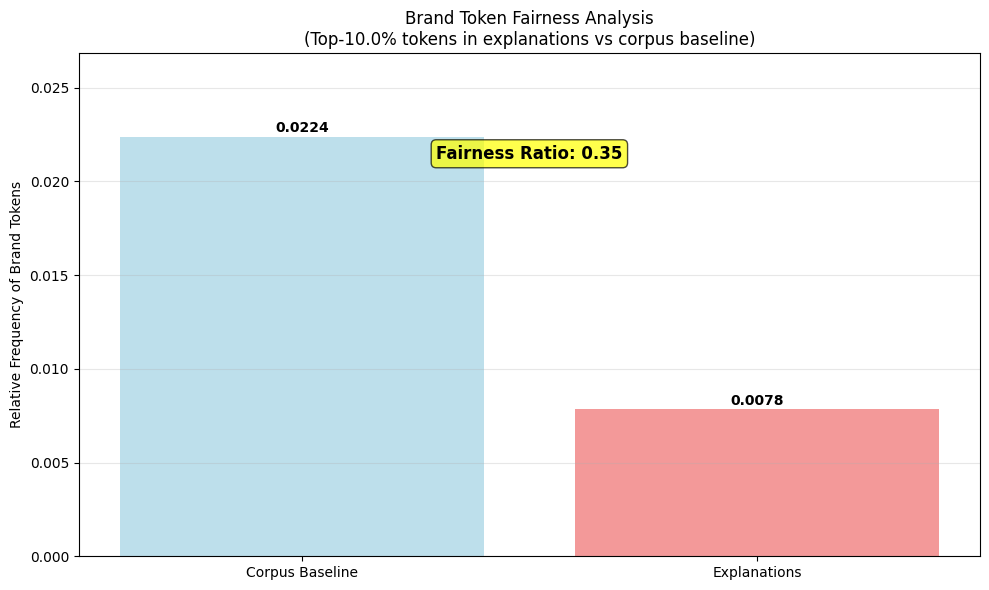

✅ Fairness analysis complete. Ratio: 0.350
✅ Saved fairness analysis to: c:\Users\hankaixin\Desktop\multitask\explainability_results_single_task\fairness_bar.png

4️⃣ Summary of Generated Files:
✅ c:\Users\hankaixin\Desktop\multitask\explainability_results_single_task\ig_example_misclassified.png
✅ c:\Users\hankaixin\Desktop\multitask\explainability_results_single_task\fairness_bar.png

🎉 Successfully generated 2 visualization files!

5️⃣ Selected Example Details:

📋 MISCLASSIFIED EXAMPLE (Index 52, Confidence: 0.344):
Text: finally got new note 7 today im username so glad whole ordeal would cool hooked u username username but wouldnt expect too upset didnt
Predicted Class: 0
Top tokens: ['finally', 'got', 'new', 'note', '7', 'today', 'im', 'username', 'so', 'glad']


In [22]:
# Generate Qualitative IG Visualizations and Fairness Analysis

def generate_qualitative_visualizations_and_fairness():
    """
    Main function to generate the required qualitative IG visualizations and fairness analysis.
    This function assumes that the main analysis has already been run and results are available.
    """
    print("🎨 Generating Qualitative IG Visualizations and Fairness Analysis")
    print("=" * 80)
    
    # Check if we have results from the main analysis
    try:
        # Try to load existing results from the main analysis
        import os
        save_dir = "explainability_results_single_task"
        
        # If the main analysis hasn't been run, run it first
        if not os.path.exists(save_dir) or not os.path.exists(os.path.join(save_dir, "xai_metrics_single_task_across_seeds.csv")):
            print("📋 Main analysis results not found. Running main analysis first...")
            results = run_ig_analysis_single_task_across_seeds(
                base_dir="./bertweet_trained_models_seeds",
                seeds=(42,123,456,789,999),
                data_path="data/cleaned_reddit_posts.csv",
                num_examples=94,
                save_dir=save_dir
            )
            explanations = None  # We'll need to regenerate these
            texts = load_test_examples("data/cleaned_reddit_posts.csv", 94)
            evaluation_results = results['rows']
        else:
            print("📋 Using existing analysis results...")
            # Load existing results
            texts = load_test_examples("data/cleaned_reddit_posts.csv", 94)
            explanations = None  # We'll regenerate these for consistency
            evaluation_results = None  # We'll load from CSV if needed
        
        # Ensure we have the necessary data
        if explanations is None:
            print("🔄 Regenerating explanations for qualitative analysis...")
            # Load models
            seed_models = load_single_task_models_by_seeds("./bertweet_trained_models_seeds", (42,123,456,789,999))
            ref_model = seed_models[0]  # Use seed 42 as reference
            
            # Generate explanations using reference model
            explanations = generate_single_task_explanations(texts, ref_model)
            
            # Generate evaluation results if needed
            if evaluation_results is None:
                evaluation_results = evaluate_single_task_explanations_across_seeds(explanations, seed_models)
        
        print(f"✅ Loaded {len(explanations)} explanations and {len(evaluation_results)} evaluation results")
        
        # Step 1: Select examples for qualitative analysis
        print("\n1️⃣ Selecting Examples for Qualitative Analysis...")
        selected_examples = select_examples_for_qualitative_analysis(explanations, evaluation_results)
        
        # Step 2: Generate qualitative visualizations
        print("\n2️⃣ Generating Qualitative IG Visualizations...")
        
        # Create output directory
        os.makedirs(save_dir, exist_ok=True)
        
        # Generate correct example visualization
        if selected_examples['correct'] is not None:
            idx, explanation, eval_result, confidence = selected_examples['correct']
            
            print(f"\n📊 Generating correct example visualization (Example {idx})...")
            print(f"📝 Text: {explanation['text'][:100]}...")
            print(f"🎯 Predicted class: {explanation['predicted_class']}, Confidence: {confidence:.3f}")
            
            # Clean tokens for visualization
            clean_tokens, clean_scores = clean_tokens_for_visualization(
                explanation['raw_tokens'], explanation['raw_scores']
            )
            
            # Generate visualization
            correct_path = os.path.join(save_dir, "ig_example_correct.png")
            visualize_token_attributions(
                tokens=clean_tokens,
                attributions=clean_scores,
                title=f"IG Attribution - Correct Classification (Confidence: {confidence:.3f})",
                outfile=correct_path,
                original_text=explanation['text']
            )
            
            print(f"✅ Saved correct example to: {os.path.abspath(correct_path)}")
        else:
            print("⚠️ No correct example available for visualization")
        
        # Generate misclassified example visualization
        if selected_examples['misclassified'] is not None:
            idx, explanation, eval_result, confidence = selected_examples['misclassified']
            
            print(f"\n📊 Generating misclassified example visualization (Example {idx})...")
            print(f"📝 Text: {explanation['text'][:100]}...")
            print(f"🎯 Predicted class: {explanation['predicted_class']}, Confidence: {confidence:.3f}")
            
            # Clean tokens for visualization
            clean_tokens, clean_scores = clean_tokens_for_visualization(
                explanation['raw_tokens'], explanation['raw_scores']
            )
            
            # Generate visualization
            misclassified_path = os.path.join(save_dir, "ig_example_misclassified.png")
            visualize_token_attributions(
                tokens=clean_tokens,
                attributions=clean_scores,
                title=f"IG Attribution - Misclassified Example (Confidence: {confidence:.3f})",
                outfile=misclassified_path,
                original_text=explanation['text']
            )
            
            print(f"✅ Saved misclassified example to: {os.path.abspath(misclassified_path)}")
        else:
            print("⚠️ No misclassified example available for visualization")
        
        # Step 3: Generate fairness analysis (optional)
        print("\n3️⃣ Generating Fairness Analysis...")
        
        fairness_path = os.path.join(save_dir, "fairness_bar.png")
        fairness_metrics = analyze_brand_token_fairness(
            explanations=explanations,
            texts=texts,
            save_path=fairness_path,
            k_ratio=0.1  # Use same k as faithfulness evaluation
        )
        
        print(f"✅ Saved fairness analysis to: {os.path.abspath(fairness_path)}")
        
        # Step 4: Print summary of generated files
        print("\n4️⃣ Summary of Generated Files:")
        print("=" * 50)
        
        generated_files = []
        
        if selected_examples['correct'] is not None:
            correct_path = os.path.join(save_dir, "ig_example_correct.png")
            if os.path.exists(correct_path):
                generated_files.append(os.path.abspath(correct_path))
                print(f"✅ {os.path.abspath(correct_path)}")
        
        if selected_examples['misclassified'] is not None:
            misclassified_path = os.path.join(save_dir, "ig_example_misclassified.png")
            if os.path.exists(misclassified_path):
                generated_files.append(os.path.abspath(misclassified_path))
                print(f"✅ {os.path.abspath(misclassified_path)}")
        
        fairness_path = os.path.join(save_dir, "fairness_bar.png")
        if os.path.exists(fairness_path):
            generated_files.append(os.path.abspath(fairness_path))
            print(f"✅ {os.path.abspath(fairness_path)}")
        
        print(f"\n🎉 Successfully generated {len(generated_files)} visualization files!")
        
        # Step 5: Show selected example texts
        print("\n5️⃣ Selected Example Details:")
        print("=" * 50)
        
        if selected_examples['correct'] is not None:
            idx, explanation, eval_result, confidence = selected_examples['correct']
            print(f"\n📋 CORRECT EXAMPLE (Index {idx}, Confidence: {confidence:.3f}):")
            print(f"Text: {explanation['text']}")
            print(f"Predicted Class: {explanation['predicted_class']}")
            print(f"Top tokens: {clean_tokens_for_visualization(explanation['raw_tokens'], explanation['raw_scores'])[0][:10]}")
        
        if selected_examples['misclassified'] is not None:
            idx, explanation, eval_result, confidence = selected_examples['misclassified']
            print(f"\n📋 MISCLASSIFIED EXAMPLE (Index {idx}, Confidence: {confidence:.3f}):")
            print(f"Text: {explanation['text']}")
            print(f"Predicted Class: {explanation['predicted_class']}")
            print(f"Top tokens: {clean_tokens_for_visualization(explanation['raw_tokens'], explanation['raw_scores'])[0][:10]}")
        
        return {
            'generated_files': generated_files,
            'selected_examples': selected_examples,
            'fairness_metrics': fairness_metrics
        }
        
    except Exception as e:
        print(f"❌ Error during qualitative analysis: {e}")
        import traceback
        traceback.print_exc()
        return None

# Run the qualitative analysis
qualitative_results = generate_qualitative_visualizations_and_fairness()
